In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ast import literal_eval
import osmnx as ox

from shapely.geometry import Polygon
import matplotlib
import networkx as nx

In [2]:
# reading road construction polygons
road_construction = pd.read_csv('data/hungary_road_construction.csv',sep=";",index_col=None,header=None)
road_construction.columns = ["name","year","month","day","points"]
road_construction.head()

,name,year,month,day,points
0,Polgári Tisza-hid,2002,10.0,1.0,"[[21.0552074392,47.8535623743],[21.0510017355,..."
1,Szekszard Szent Laszlo-hid,2003,7.0,4.0,"[[18.8875748594,46.3498790197],[18.887274452,4..."
2,Dunaujvaros Pentele-hid,2007,7.0,23.0,"[[18.9884702044,46.8892504416],[18.9010945635,..."
3,M3 Fuzesabony-Polgar,2002,NaN,NaN,"[[20.4282135249,47.7251911319],[20.4055542231,..."
4,M3 Polgar-Gorbehaza,2004,9.0,NaN,"[[21.2596564086,47.7818136227],[21.1813788207,..."


<AxesSubplot:>

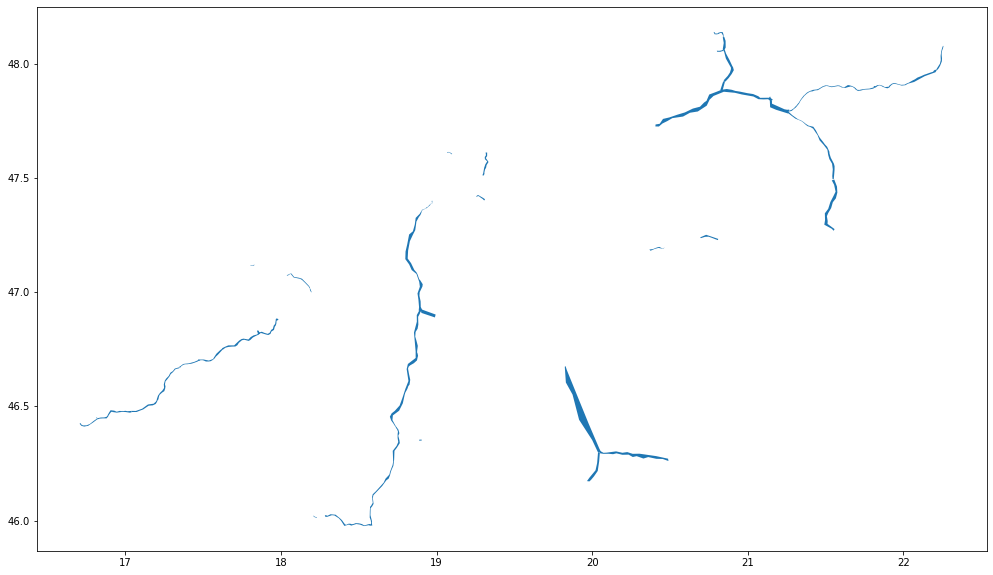

In [3]:
# converting list of list strings to actual Python objects
road_construction["points"] = road_construction["points"].map(literal_eval)
# converting list of lists to Polygon objects
road_construction["geometry"] = road_construction["points"].map(Polygon)
# converting pandas to geodataframe
road_construction = gpd.GeoDataFrame(road_construction, geometry = "geometry", crs = "epsg:4326")
fig,ax = plt.subplots(1,1,figsize=(20,10))
road_construction.plot(ax=ax)

In [4]:
# reading node and edge shapefiles
nodes_s = gpd.read_file("data/hungary_main_roads_nodes.shp").set_index("osmid")
edges_s = gpd.read_file("data/hungary_main_roads_edges.shp")
# more complicated data has been stored separately from the shapefile
temp = pd.read_csv("data/hungary_main_roads_edges_extension.csv")
temp["osmid"] = temp["osmid"].map(literal_eval)
edges_s = pd.merge(edges_s,temp)
del temp

In [5]:
# which edges intersect with the road construction dataframe
intersections = gpd.sjoin(edges_s, road_construction)
intersections.head()

,u,v,key,geometry,osmid,oneway,lanes,ref,highway,length,...,width,service,maxspeed_new,speedcolor,index_right,name_right,year,month,day,points
79,686550313,2144826801,0,"LINESTRING (18.27575 46.05365, 18.27524 46.052...","[326353477, 54511341, 326353478]",False,2,578,primary,3998.054,...,NaN,NaN,90.000000,#21918c,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."
85,686550337,688358294,0,"LINESTRING (18.27652 46.05478, 18.27674 46.054...","[355078186, 355078192, 355078198, 355078200, 3...",False,"['6', '2', '4', '3']",57,primary,26414.185,...,NaN,NaN,84.767127,#26818e,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."
90,686550399,2144826788,0,"LINESTRING (18.28787 46.01851, 18.28749 46.019...","[204479810, 308721679, 204479807]",False,2,578,primary,304.186,...,NaN,NaN,90.000000,#21918c,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."
91,686550399,2144826756,0,"LINESTRING (18.28787 46.01851, 18.28788 46.018...",204479848,True,1,578,primary,47.231,...,NaN,NaN,90.000000,#21918c,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."
95,687431058,687433176,0,"LINESTRING (18.23613 46.01250, 18.23791 46.012...","[269888480, 269888481, 149403364, 293029797, 1...",True,"['2', '3']",M60,motorway,4157.165,...,NaN,NaN,125.888139,#dde318,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."


In [81]:
# getting Budapest as a point
budapest = gpd.read_file('../../data/hungary-osm/gis_osm_places_a_free_1.shp').loc[312]
budapest["geometry"] = budapest["geometry"].centroid

# reading OSM settlements
settlements = gpd.read_file('../../data/hungary-osm/gis_osm_places_free_1.shp')
# adding Budapest, that was a polygon
settlements = pd.concat([settlements, pd.DataFrame([budapest])])

# plotting high-speed roads that intersect with the construction dataframe
fig,ax = plt.subplots(1,1,figsize=(20,10))
intersections[intersections["maxspeed_new"]>90].plot(ax=ax)
# plotting country boundary
gpd.read_file('../../data/hungary-gadm/gadm36_HUN_0.shp').boundary.plot(ax=ax,color='darkgrey')
# plotting settlements
settlements[settlements["fclass"]=="city"].plot(ax=ax,color="green")

In [44]:
def trim_graph(year):
    """
    This function takes a year as an input, deletes edges form the edge dataframe
    that are newer than the given year, searches for largest connected component in
    the network constructed from the smaller edge set, and returns an osmnx graph
    using only the largest connected component.
    """
    # get high-speed edges that intersect with the road construction dataframe
    trimmed_edges = edges_s[edges_s.index.map(lambda i: i not in intersections[(intersections["year"]>year)&(intersections["maxspeed_new"]>90)].index)].set_index(["u","v","key"])
    # calculate edge travel times
    trimmed_edges["time"] = trimmed_edges["length"]/1000 / trimmed_edges["maxspeed_new"]
    # create graph
    G = ox.graph_from_gdfs(nodes_s,trimmed_edges)
    # get largest connected component
    conn_comp_nodes = sorted(nx.connected_components(ox.get_undirected(G)),key=len)[-1]
    # return largest connected component and corresponding nodes
    return \
        ox.graph_from_gdfs(nodes_s.loc[conn_comp_nodes],trimmed_edges[trimmed_edges.index.map(lambda i: i[0] in conn_comp_nodes and i[1] in conn_comp_nodes)]),\
        nodes_s.loc[conn_comp_nodes]

In [94]:
# the 19 selected cities
cities = settlements[settlements["fclass"]=="city"]
cities

,osm_id,code,fclass,population,name,geometry
9,17550787,1001,city,140237,Pécs,POINT (18.22804 46.07659)
44,25553427,1001,city,30963,Szekszárd,POINT (18.70166 46.34849)
61,25926749,1001,city,59777,Kaposvár,POINT (17.78869 46.35647)
69,26757722,1001,city,51168,Eger,POINT (20.37437 47.89899)
71,26757724,1001,city,200974,Debrecen,POINT (21.62598 47.53140)
86,30453579,1001,city,159074,Szeged,POINT (20.14860 46.25463)
107,32443002,1001,city,109651,Kecskemét,POINT (19.69281 46.90808)
110,32444521,1001,city,58002,Békéscsaba,POINT (21.09854 46.67980)
119,64622559,1001,city,150695,Miskolc,POINT (20.79004 48.10306)
120,64624269,1001,city,132735,Győr,POINT (17.63468 47.68761)


In [90]:
graphs = {}
nodes = {}
# saving road networks for each year
# saving the node dataframe separately
# makes calculations easier
for y in range(2002,2013):
    test, nodes_test = trim_graph(y)
    graphs[y] = ox.get_undirected(test)
    nodes[y] = nodes_test
#     ox.io.save_graphml(trim_graph(y),f'data/hungary_road_network_{y}.graphml')

In [91]:
from itertools import product
from warnings import filterwarnings

In [96]:
filterwarnings('ignore')

In [97]:
sp = {} # storing shortest paths
res = [] # storing result
# for all years
for y in range(2002,2013):
    # for all city pairs
    for c1_orig, c2_orig in product(cities["osm_id"],cities["osm_id"]):
        # listing pairs only once
        if c1_orig < c2_orig:
            c1_geom = cities[cities["osm_id"]==c1_orig]["geometry"].iloc[0] # getting point of c1
            c2_geom = cities[cities["osm_id"]==c2_orig]["geometry"].iloc[0] # getting point of c2
            c1 = nodes[y].distance(c1_geom).idxmin() # which graph node is closest to c1
            c2 = nodes[y].distance(c2_geom).idxmin() # which graph node is closest to c2
            sp_nodelist = nx.shortest_path(graphs[y], source = c1, target = c2, weight="time") # list nodes of the shortest path
            sp_edgelist = list(zip(sp_nodelist[:-1],sp_nodelist[1:])) # zip sp nodelist into edges
            sp[y] = sp_edgelist # store shortest path edgelist
            # append output
            res.append({
                "year": y,
                "source" : cities[cities["osm_id"]==c1_orig]["name"].iloc[0],
                "target" :cities[cities["osm_id"]==c2_orig]["name"].iloc[0],
                "travel_time": nx.shortest_path_length(graphs[y], source = c1, target = c2, weight="time"),
                "length": nx.shortest_path_length(graphs[y], source = c1, target = c2, weight="length"),
            })

In [76]:
# saving results
pd.DataFrame.from_dict(res).to_csv("data/shortest_paths.csv",index=False,header=True)

<AxesSubplot:>

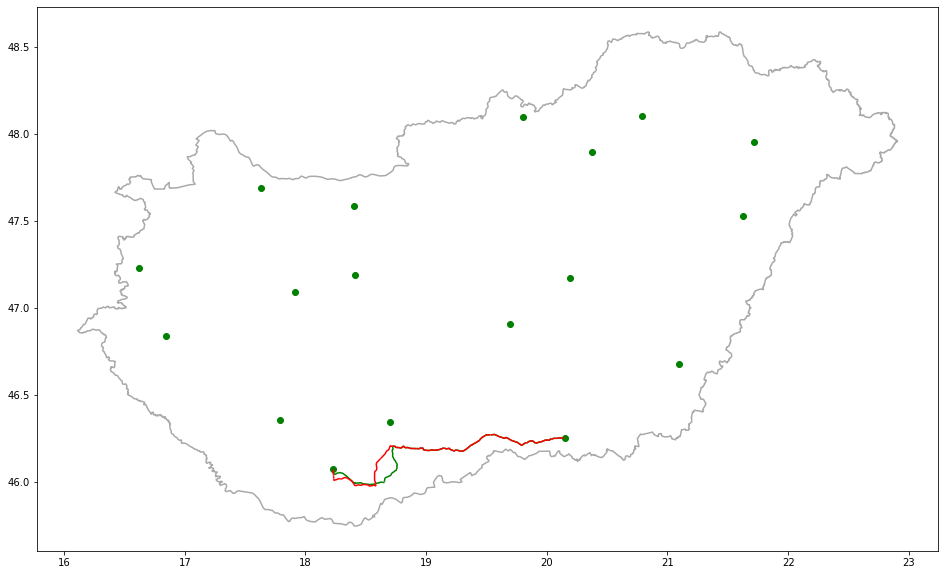

In [57]:
# testing the Szeged-Pecs shortest paths for years 2002 and 2012
fig,ax = plt.subplots(1,1,figsize=(20,10))
gpd.read_file('../../data/hungary-gadm/gadm36_HUN_0.shp').boundary.plot(ax=ax,color='darkgrey')
settlements[settlements["fclass"]=="city"].plot(ax=ax,color="green")
edges_s[edges_s.apply(lambda r: (r["u"],r["v"]) in set(sp[2002]),axis=1)].plot(ax=ax,color='g')
edges_s[edges_s.apply(lambda r: (r["u"],r["v"]) in set(sp[2012]),axis=1)].plot(ax=ax,color='r')